In [58]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import random
from sklearn.preprocessing import LabelEncoder
import os



In [4]:
pos_df = pd.read_csv('positive10k.txt', sep='\t', header=None) 
neg_df = pd.read_csv('negative10k.txt', sep='\t', header=None)
cmt_msg_df = pd.read_csv('commit-messages.txt', sep='\t', header=None) 

pos_df.shape, neg_df.shape, cmt_msg_df.shape

((9935, 1), (9719, 1), (14195, 1))

In [12]:
pos_df[1]='positive'
neg_df[1]='negative'
cmt_msg_df[1]='enhancement'

In [18]:
df = pd.DataFrame(pos_df)
df = df.append(neg_df)
df = df.append(cmt_msg_df[:10000])
df.shape

(29654, 2)

In [19]:
df = df.sample(frac = 1, random_state = 42)
df

,0,1
5977,consumed as system properties in log4j2.xml an...,enhancement
4810,The afterResolve action would then try to acce...,enhancement
9859,"This partially reverts commit 1f8ea54c.,Upgrad...",enhancement
8643,I like it a lot I like that you can go on diff...,positive
6432,"Polish ""Configure SAML 2.0 Service Provider vi...",enhancement
...,...,...
1921,Align buildSrc's Kotlin version with main proj...,enhancement
5390,Love these games,positive
860,Good game I can play it but i wish it didn't h...,positive
5860,Poor Navigation is nice but hard to use if com...,negative


<AxesSubplot:>

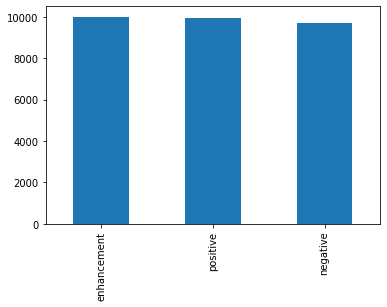

In [21]:
df[1].value_counts().plot(kind='bar')

In [23]:
from sklearn.model_selection import train_test_split
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df[0].to_numpy(),
                                                                            df[1].to_numpy(),
                                                                            test_size=0.2, # dedicate 10% of samples to validation set
                                                                            random_state=42)
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)


(23723, 23723, 5931, 5931)

In [29]:
max_vocab_length = 10000
avg_sentence_length = int(np.mean([len(s.split()) for s in train_sentences]))
avg_sentence_length

15

In [31]:
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                     standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    output_sequence_length=avg_sentence_length)
text_vectorizer.adapt(train_sentences)


In [34]:
# Choose a random sentence from the training dataset and tokenize it

random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
  Fix detection logic for embedded databases      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  43, 1131,  814,   11, 1489, 4960,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [35]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'to', 'it']
Bottom 5 least common words: ['voulais', 'voucher', 'voting', 'vostro', 'vostra']


In [37]:
# integer encode
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_test = label_encoder.transform(val_labels)
y_train[0],y_test[0]

(0, 0)

In [40]:
X_train = [ text_vectorizer([str]) for str in train_sentences] 
X_test = [ text_vectorizer([str]) for str in val_sentences]
X_train[0].shape, X_test[0].shape

(TensorShape([1, 15]), TensorShape([1, 15]))

In [41]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 10000, and output embedding dimension of size 128 we set at the top
    tf.keras.layers.Embedding(max_vocab_length, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(128, activation='relu'),
    # Add a Dense layer with 3 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,576,451
Trainable params: 1,576,451
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [60]:
num_epochs = 5
history = model.fit(tf.squeeze(X_train), y_train, epochs=num_epochs, verbose=2, 
                    validation_data=(tf.squeeze(X_test), y_test),
                    callbacks=[cp_callback])

Epoch 1/5

Epoch 1: saving model to training_1/cp.ckpt
742/742 - 27s - loss: 0.0685 - accuracy: 0.9774 - val_loss: 0.3410 - val_accuracy: 0.9041 - 27s/epoch - 36ms/step
Epoch 2/5

Epoch 2: saving model to training_1/cp.ckpt
742/742 - 29s - loss: 0.0532 - accuracy: 0.9820 - val_loss: 0.5014 - val_accuracy: 0.8968 - 29s/epoch - 39ms/step
Epoch 3/5

Epoch 3: saving model to training_1/cp.ckpt
742/742 - 29s - loss: 0.0489 - accuracy: 0.9830 - val_loss: 0.4566 - val_accuracy: 0.8988 - 29s/epoch - 39ms/step
Epoch 4/5

Epoch 4: saving model to training_1/cp.ckpt
742/742 - 28s - loss: 0.0400 - accuracy: 0.9859 - val_loss: 0.6306 - val_accuracy: 0.8828 - 28s/epoch - 37ms/step
Epoch 5/5

Epoch 5: saving model to training_1/cp.ckpt
742/742 - 26s - loss: 0.0373 - accuracy: 0.9874 - val_loss: 0.5551 - val_accuracy: 0.8977 - 26s/epoch - 35ms/step


In [61]:
!mkdir -p saved_model
model.save('saved_model/my_model')

2022-02-12 22:10:21.977457: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


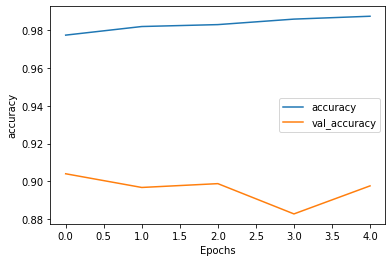

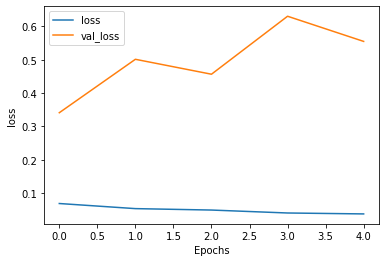

In [63]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [66]:
new_model = tf.keras.models.load_model('saved_model/my_model')
# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,576,451
Trainable params: 1,576,451
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Evaluate the restored model
loss, acc = new_model.evaluate(tf.squeeze(X_test), y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

186/186 - 2s - loss: 0.5551 - accuracy: 0.8977 - 2s/epoch - 13ms/step
Restored model, accuracy: 89.77%


In [68]:
# Prediction for positive comment
prediction=model.predict(text_vectorizer(["This library is very useful."]))
label_encoder.inverse_transform([np.argmax(prediction)])

array(['positive'], dtype=object)

In [69]:
# Prediction for negative comment
prediction=model.predict(text_vectorizer(["There are lot of bugs"]))
label_encoder.inverse_transform([np.argmax(prediction)])

array(['negative'], dtype=object)

In [70]:
# Prediction for enhancement comment
prediction=model.predict(text_vectorizer(["Migrate to Postgres db"]))
label_encoder.inverse_transform([np.argmax(prediction)])

array(['enhancement'], dtype=object)